Dropout statistics data analyis
=====
This notebook summarizes the efforts made in the analysis of statistical dropout data for the standard 4130cu. in. array with Bolt LLXT guns. Other arrays or dropout rules may easily be analyzed by saving this Jupyter Notebook with a new name and feed in the raw statistics (dan) files for the relavant source. Dropout rules are specified in this notebook under the Heading called Dropout Rule.

## Motivation
Dropout specs and modeling has been a topic for discussion for years:
The tolerance specs are sharp, resulting in a red or green box in a dropout matrix, but the matrix is based on a set of assumptions that are quite inaccurate.

<li>Source modeling code and calibration: old vs new matters</li>

<li>Temperature sensitivity</li>

<li>We are assuming a static and 100% correctly deployed source.</li>

<li>Dropouts are done on vertical farfields, even if relevant farfields are mostly non-vertical</li>

<li>Origin of specs (operational more than geophysical, “nice round numbers”).</li>

<li>Etc.</li>

Reshoots due to dropouts are costly. A revision is in line with a streamlining/cost-cutting philosophy
There is no guarantee that a reshoot results in improved data quality
Current practice of bespoke dropout matrix per project is error prone and resource demanding. And triggers discussion if new modeling should be used to allow for more dropped guns.

Shot-to-shot designature: Some possibility to correct for a range of bad shots.

Include perl script

# Importing modules for plotting

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Setting some parameters for reading the input


Below, the header of two dan-files (broadband and conventional/cross-correlation) are listed to confirm the modeling parameters used in Nucleus. First specify the path to the dan files for the dataset to analyze:

In [2]:
path = "./batch_4130/"

In [3]:
file = "4130T__040_2000_080_5.dan"
f = open(path + "bb_" + file)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 56:
        print(i, line)


0 DROPOUT SIGNATURE STATISTICS :
1 
2 Project : 2018_06_MasterMatrix
3 Dataset : 12drop
4 
5 File format number   : 8
6 Statistics created by Nucleus+ version 2.7.1
7 Statistics created by Marine source modelling version 1.11.1
8 
9 User reference       : 
10 
11 Computed dropout signature statistics.
12 Correlation measure  : NA.
13 
14 Project name               : 2018_06_MasterMatrix
15 Dropout signature dataset  : 12drop
16 Dropout array name         : 4130T__040_2000_080
17 Reference array name       : 4130T__040_2000_080
18 Instrument filter          : GeoStr LChyd_3/7-214/341
19 
20 Frequency analysis option  : Average absolute spectral deviation.
21 Bandwidth of analysis (Hz) :   5.00  -  200.00
22 
23 Sampling interval (ms)     :      0.50
24 Water velocity (m/s)       :   1470.91
25 Water temperature (C)      :      5.00
26 Notional refl. coeff       :     -1.00
27 Farfield refl. coeff       :      0.00
28 Farfield dip angle (deg)   :      0.00
29 Farfield azimuth (deg)     :

In [4]:
file = "4130T__040_2000_080_5.dan"
f = open(path + "cc_" + file)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 56:
        print(i, line)


0 DROPOUT SIGNATURE STATISTICS :
1 
2 Project : 2018_06_MasterMatrix
3 Dataset : 12drop_cc
4 
5 File format number   : 8
6 Statistics created by Nucleus+ version 2.7.1
7 Statistics created by Marine source modelling version 1.11.1
8 
9 User reference       : 
10 
11 Computed dropout signature statistics.
12 Correlation measure  : Cross correlation.
13 
14 Project name               : 2018_06_MasterMatrix
15 Dropout signature dataset  : 12drop_cc
16 Dropout array name         : 4130T__040_2000_080
17 Reference array name       : 4130T__040_2000_080
18 Instrument filter          : GeoStr LChyd_3/7-214/341
19 
20 Primary pick window (ms)   : -68.50  -   30.00
21 Bubble pick mode           : Manual
22 Bubble pick window (ms)    :  50.00  -  200.00
23 
24 Amplitude option           : Positive peak amplitude.
25 Frequency analysis option  : Average absolute spectral deviation.
26 Bandwidth of analysis (Hz) :  10.00  -   70.00
27 
28 Sampling interval (ms)     :      0.50
29 Water velocity (m

Setting the numbers of lines to skip. This is for the 4130 array.

In [5]:
#bb statistics
onegunskip = 43
twogunskip = 74
spareskip = 539
eof = 557

#conventional statistics
onegunskipcc = 55
twogunskipcc = 86
spareskipcc = 551
eofcc = 569

arrayvol = '4130T'
arraydepth = [4, 5, 6, 7, 8, 9]
subsep = [8, 10]
temp = [5, 10, 15, 20, 25]
prefix = ['bb', 'cc']

Setting file name

In [6]:
filenames = []

for a in arraydepth:
	for s in subsep:
		for t in temp:
			if s < 10: 
				filenames.append(arrayvol + '__0' + str(a) + '0_2000_0' + str(s) + '0_' + str(t) + '.dan')
			else:
				filenames.append(arrayvol + '__0' + str(a) + '0_2000_' + str(s) + '0_' + str(t) + '.dan')

Just checking the file names:

In [7]:
count = 0
for filename in filenames:
    if count < 10:
        print(filename)
    count += 1
print(len(filenames))

4130T__040_2000_080_5.dan
4130T__040_2000_080_10.dan
4130T__040_2000_080_15.dan
4130T__040_2000_080_20.dan
4130T__040_2000_080_25.dan
4130T__040_2000_100_5.dan
4130T__040_2000_100_10.dan
4130T__040_2000_100_15.dan
4130T__040_2000_100_20.dan
4130T__040_2000_100_25.dan
60


## Modeling Parameters
This report analyse statistical values of the following dropout scenarios:
<li>Temperatures: 5, 10, 15, 20, 25</li>
<li>Depths 4-9m; 1m increment</li>
<li>Subarray separation: 8 and 10m</li>
<li>Bolt and GII guns</li>
<li>Broadband (refl coeff zero) and conventional (refl coeff -1)</li>
Total: 123 360 combinations
<li>60 source/temperature combinations</li>
<li>2 modelings per source (broadband and conv)</li>
<li>2 gun types</li>
<li>All single and two gun dropouts with spare gun substitution</li>
<li>514 dropout combinations per source (nominal source always used as reference)</li>

The datasets are analyzed separately for Gun type to detect systematic differences.


Defining the column names:

In [8]:
columns_one_gun_bb_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'AvgdB', 'MaxdB', 'MaxPhase']
columns_two_gun_bb_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase']
columns_spare_gun_bb_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase']	
columns_one_gun_cc_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'Peak', 'Peakch','PtoB','PtoBch', 'x-corr', 'AvgdB', 'MaxdB']
columns_two_gun_cc_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB', 'MaxdB']
columns_spare_gun_cc_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB', 'MaxdB']

Statistical data defined as panda dataframes:

In [9]:
stat_one_gun_bb_raw = pd.DataFrame()
stat_two_gun_bb_raw = pd.DataFrame()
stat_spare_gun_bb_raw = pd.DataFrame()
stat_one_gun_cc_raw = pd.DataFrame()
stat_two_gun_cc_raw = pd.DataFrame()
stat_spare_gun_cc_raw = pd.DataFrame()

Reading data from files into dataframes:

In [10]:
#path = "./batch_4130/"
for filename in filenames:
    temp_stat_one_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_one_gun_bb_raw, skiprows=onegunskip, delim_whitespace=True, nrows=twogunskip-onegunskip)
    temp_stat_one_gun_bb_raw['filename'] = filename
    temp_stat_one_gun_bb_raw['Depth'] = int(filename[7:10])
    temp_stat_one_gun_bb_raw['Subsep'] = int(filename[16:19])
    temp_stat_one_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_one_gun_bb_raw = stat_one_gun_bb_raw.append(temp_stat_one_gun_bb_raw)
    temp_stat_one_gun_bb_raw = []
    
    temp_stat_two_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_two_gun_bb_raw, skiprows=twogunskip, delim_whitespace=True, nrows=spareskip-twogunskip)
    temp_stat_two_gun_bb_raw['filename'] = filename
    temp_stat_two_gun_bb_raw['Depth'] = int(filename[7:10])
    temp_stat_two_gun_bb_raw['Subsep'] = int(filename[16:19])
    temp_stat_two_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_two_gun_bb_raw = stat_two_gun_bb_raw.append(temp_stat_two_gun_bb_raw)
    temp_stat_two_gun_bb_raw = []
    
    temp_stat_spare_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_spare_gun_bb_raw, skiprows=spareskip, delim_whitespace=True, nrows=eof-spareskip)
    temp_stat_spare_gun_bb_raw['filename'] = filename
    temp_stat_spare_gun_bb_raw['Depth'] = int(filename[7:10])
    temp_stat_spare_gun_bb_raw['Subsep'] = int(filename[16:19])
    temp_stat_spare_gun_bb_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_spare_gun_bb_raw = stat_spare_gun_bb_raw.append(temp_stat_spare_gun_bb_raw)
    temp_stat_spare_gun_bb_raw = []
    
    temp_stat_one_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_one_gun_cc_raw, skiprows=onegunskipcc, delim_whitespace=True, nrows=twogunskipcc-onegunskipcc)
    temp_stat_one_gun_cc_raw['filename'] = filename
    temp_stat_one_gun_cc_raw['Depth'] = int(filename[7:10])
    temp_stat_one_gun_cc_raw['Subsep'] = int(filename[16:19])
    temp_stat_one_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_one_gun_cc_raw = stat_one_gun_cc_raw.append(temp_stat_one_gun_cc_raw)
    temp_stat_one_gun_cc_raw = []
    
    temp_stat_two_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_two_gun_cc_raw, skiprows=twogunskipcc, delim_whitespace=True, nrows=spareskipcc-twogunskipcc)
    temp_stat_two_gun_cc_raw['filename'] = filename
    temp_stat_two_gun_cc_raw['Depth'] = int(filename[7:10])
    temp_stat_two_gun_cc_raw['Subsep'] = int(filename[16:19])
    temp_stat_two_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_two_gun_cc_raw = stat_two_gun_cc_raw.append(temp_stat_two_gun_cc_raw)
    temp_stat_two_gun_cc_raw = []
    
    temp_stat_spare_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_spare_gun_cc_raw, skiprows=spareskipcc, delim_whitespace=True, nrows=eofcc-spareskipcc)
    temp_stat_spare_gun_cc_raw['filename'] = filename
    temp_stat_spare_gun_cc_raw['Depth'] = int(filename[7:10])
    temp_stat_spare_gun_cc_raw['Subsep'] = int(filename[16:19])
    temp_stat_spare_gun_cc_raw['Temperature'] = int(filename[20:22].replace('.',''))
    stat_spare_gun_cc_raw = stat_spare_gun_cc_raw.append(temp_stat_spare_gun_cc_raw)
    temp_stat_spare_gun_cc_raw = []

The follwing is a lambda function that converts to string and adds zeros to a total length of 2 characters to the input x (which could be an int). Is later used to convert all gun numbers from int to string. (3 to "03", for example)

In [11]:
add_zero = lambda x: str(int(x)).zfill(2)

Adding all the string representations for gun numbering in a dedicated set of columns. Is later used to make array_gun_number index with a logical order. 

In [12]:
stat_one_gun_bb_raw['dropgun1_str'] = stat_one_gun_bb_raw['dropgun1'].apply(add_zero)
stat_two_gun_bb_raw['dropgun1_str'] = stat_two_gun_bb_raw['dropgun1'].apply(add_zero)
stat_two_gun_bb_raw['dropgun2_str'] = stat_two_gun_bb_raw['dropgun2'].apply(add_zero)
stat_spare_gun_bb_raw['dropgun1_str'] = stat_spare_gun_bb_raw['dropgun1'].apply(add_zero)
stat_spare_gun_bb_raw['dropgun2_str'] = stat_spare_gun_bb_raw['dropgun2'].apply(add_zero)
stat_one_gun_cc_raw['dropgun1_str'] = stat_one_gun_cc_raw['dropgun1'].apply(add_zero)
stat_two_gun_cc_raw['dropgun1_str'] = stat_two_gun_cc_raw['dropgun1'].apply(add_zero)
stat_two_gun_cc_raw['dropgun2_str'] = stat_two_gun_cc_raw['dropgun2'].apply(add_zero)
stat_spare_gun_cc_raw['dropgun1_str'] = stat_spare_gun_bb_raw['dropgun1'].apply(add_zero)
stat_spare_gun_cc_raw['dropgun2_str'] = stat_spare_gun_bb_raw['dropgun2'].apply(add_zero)

Printing some statistics to check that dataframes are ok (Remove hash for what you want to print)

In [13]:
#print('stat_one_gun_bb_raw: ')
#print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.tail())
#print(stat_one_gun_cc_raw)
#print(stat_two_gun_bb_raw.info())
#print('stat_spare_gun')

#print(stat_one_gun_cc_raw.head())
#print(stat_one_gun_cc_raw.tail())
#print('stat_two_gun_cc_raw: ')
#print(stat_two_gun_cc_raw.head())
#print(stat_two_gun_cc_raw.info())
# print('stat_spare_gun_cc_raw')
print(stat_spare_gun_cc_raw.tail())
# print(stat_spare_gun_cc_raw.info())
#print(len(stat_one_gun_bb_raw), len(stat_two_gun_bb_raw), len(stat_spare_gun_bb_raw))
#print(len(stat_one_gun_cc_raw), len(stat_two_gun_cc_raw), len(stat_spare_gun_cc_raw))

    droparray1  dropgun1  droparray2  dropgun2  gunvolume1  gunvolume2  Peak  \
13           2        11           3        -4         150         150  67.7   
14           2        12           3        -4         150         150  67.7   
15           3         1           3        -4         150         150  67.5   
16           3         2           3        -4         150         150  67.5   
17           3         3           3        -4         150         150  67.7   

    Peakch  PtoB  PtoBch  x-corr  AvgdB  MaxdB                    filename  \
13    -0.0  17.4    -1.2  0.9998   0.13   -0.8  4130T__090_2000_100_25.dan   
14    -0.0  17.4    -1.4  0.9998   0.13   -0.8  4130T__090_2000_100_25.dan   
15    -0.3  16.8    -4.5  0.9996   0.16   -1.1  4130T__090_2000_100_25.dan   
16    -0.3  16.8    -4.3  0.9996   0.15   -1.1  4130T__090_2000_100_25.dan   
17     0.0  17.6     0.1  1.0000   0.01   -0.1  4130T__090_2000_100_25.dan   

    Depth  Subsep  Temperature dropgun1_str dropgu

Next step is to copy dataframes to identical copy with "all" postfix. Then later, the mastermatrix filter will be applied to the original dataframes. The "all" dataframes will contain the unfiltered data material.

In [14]:
print(len(stat_two_gun_bb_raw))

27900


In [15]:
stat_two_gun_bb_raw['legal'] = stat_two_gun_bb_raw.apply(lambda row: 1 if (row['AvgdB'] < 0.85) & 
                                                         (row['MaxdB'] < 3) & 
                                                         (row['MaxPhase'] < 20) 
                                                         else 0, axis=1)

In [16]:
stat_two_gun_bb_raw.legal.value_counts()
# 1 means legal (55%), 0 means illegal (45%)

1    15513
0    12387
Name: legal, dtype: int64

In [17]:
stat_two_gun_bb_raw.dtypes

droparray1        int64
dropgun1          int64
droparray2        int64
dropgun2          int64
gunvolume1        int64
gunvolume2        int64
AvgdB           float64
MaxdB           float64
MaxPhase        float64
filename         object
Depth             int64
Subsep            int64
Temperature       int64
dropgun1_str     object
dropgun2_str     object
legal             int64
dtype: object

In [18]:
stat_two_gun_bb_raw['gun1_unique'] = stat_two_gun_bb_raw.apply(lambda row: str(row['droparray1']) + '.' + row['dropgun1_str'], axis=1)
stat_two_gun_bb_raw['gun2_unique'] = stat_two_gun_bb_raw.apply(lambda row: str(row['droparray2']) + '.' + row['dropgun2_str'], axis=1)

In [19]:
#stat_two_gun_bb_raw

In [20]:
ml_data_two_gun_bb = stat_two_gun_bb_raw[['filename', 'gun1_unique', 'gun2_unique', 'Depth', 'Subsep', 'Temperature', 'legal']]


In [21]:
#ml_data_two_gun_bb

In [22]:
def valuemapping(values_to_map):
    values = values_to_map.unique()
    mapping = {}
    for i, value in enumerate(values, 1):
        mapping[value] = i
    return mapping  

In [23]:
gun_mapping = {'1.01': 1, 
               '1.02': 2, 
               '1.03': 3, 
               '1.04': 4, 
               '1.05': 5, 
               '1.07': 6, 
               '1.09': 7, 
               '1.11': 9, 
               '1.12': 10, 
               '1.13': 11, 
               '1.14': 12, 
               '2.01': 13, 
               '2.02': 14, 
               '2.03': 15, 
               '2.05': 16, 
               '2.07': 17, 
               '2.09': 18, 
               '2.11': 19, 
               '2.12': 20, 
               '2.13': 21, 
               '3.01': 23, 
               '3.02': 24, 
               '3.03': 25, 
               '3.05': 27, 
               '3.07': 28, 
               '3.09': 29, 
               '3.10': 30, 
               '3.11': 31, 
               '3.12': 32, 
               '3.13': 33, 
               '3.14': 34}
#gun_mapping1 = valuemapping(ml_data_two_gun_bb.gun1_unique)
#gun_mapping2 = valuemapping(ml_data_two_gun_bb.gun2_unique)
print(gun_mapping)
ml_data_two_gun_bb['gun1_num'] = ml_data_two_gun_bb.gun1_unique.map(gun_mapping)
ml_data_two_gun_bb['gun2_num'] = ml_data_two_gun_bb.gun2_unique.map(gun_mapping)

{'1.01': 1, '1.02': 2, '1.03': 3, '1.04': 4, '1.05': 5, '1.07': 6, '1.09': 7, '1.11': 9, '1.12': 10, '1.13': 11, '1.14': 12, '2.01': 13, '2.02': 14, '2.03': 15, '2.05': 16, '2.07': 17, '2.09': 18, '2.11': 19, '2.12': 20, '2.13': 21, '3.01': 23, '3.02': 24, '3.03': 25, '3.05': 27, '3.07': 28, '3.09': 29, '3.10': 30, '3.11': 31, '3.12': 32, '3.13': 33, '3.14': 34}


/Volumes/Macintosh_HD/Python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Volumes/Macintosh_HD/Python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
ml_data_two_gun_bb = ml_data_two_gun_bb[['filename', 'gun1_num', 'gun2_num', 'Depth', 'Subsep', 'Temperature', 'legal']]

In [25]:
#ml_data_two_gun_bb

In [142]:
def plotmatrix(x, y, legal, title):
    plt.figure(figsize=(12, 8))
    #color= ['red' if legal == 0 else 'green']
    color= ['red' if l == 0 else 'green' for l in legal]
    plt.scatter(x, y, c=color, s=100)
    plt.xlim(0, 36)
    plt.ylim(0, 36)
    plt.title(title)
    plt.xlabel("Gun 1")
    plt.ylabel("Gun 2")
    plt.gca().invert_yaxis()
    plt.show()

In [143]:
examplefile = '4130T__070_2000_100_25.dan'

In [144]:
ml_data_example = ml_data_two_gun_bb[(ml_data_two_gun_bb['filename'] == examplefile)]


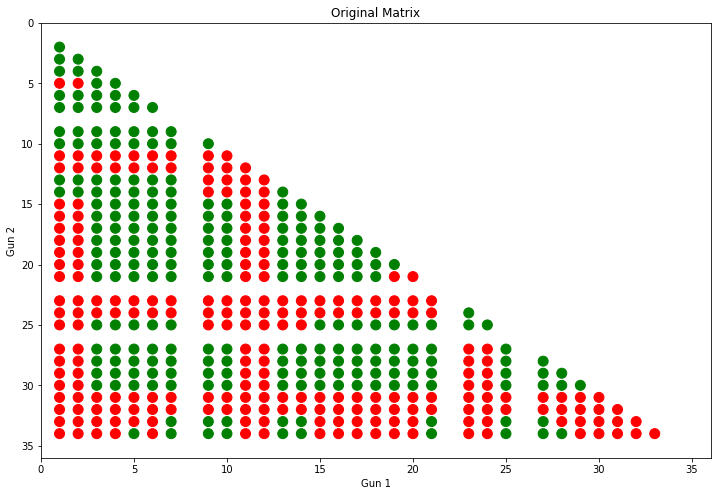

In [145]:
plotmatrix(ml_data_example.gun1_num, ml_data_example.gun2_num, ml_data_example.legal, 'Original Matrix')

In [146]:
#ml_data_two_gun_bb.corr()

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import itertools

In [148]:
def normalize_data(feature_data):
    x = feature_data.values.astype('float64')
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)
    return feature_data

In [149]:
def normalize_custom(feature_data):
    feature_data['Depth'] = feature_data.apply(lambda row: row['Depth']/10, axis=1)
    feature_data['Subsep'] = feature_data.apply(lambda row: row['Subsep']/20, axis=1)
    feature_data['Temperature'] = feature_data.apply(lambda row: row['Temperature']/5, axis=1)
    return feature_data

In [150]:
def normalize_custom_inverse(feature_data):
    feature_data['Depth'] = feature_data.apply(lambda row: row['Depth']*10, axis=1)
    feature_data['Subsep'] = feature_data.apply(lambda row: row['Subsep']*20, axis=1)
    feature_data['Temperature'] = feature_data.apply(lambda row: row['Temperature']*5, axis=1)
    return feature_data

In [151]:
def knn(training_data, training_labels, validation_data, validation_labels, maxk, avg):
    normalize_custom(training_data)
    normalize_custom(validation_data)
    k_list = []
    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    for k in range(1, maxk, 2):
        classifier = KNeighborsClassifier(n_neighbors = k, p=1)
        classifier.fit(training_data, training_labels)
        print(k, ': ', classifier.score(validation_data, validation_labels))
        k_list.append(k)
        y_predict = classifier.predict(validation_data)
        accuracies.append(metrics.accuracy_score(validation_labels, y_predict))
        recalls.append(metrics.recall_score(validation_labels, y_predict, average=avg))
        precisions.append(metrics.precision_score(validation_labels, y_predict, average=avg))
        f1s.append(metrics.f1_score(validation_labels, y_predict, average=avg))
    normalize_custom_inverse(training_data)
    normalize_custom_inverse(validation_data)
    return k_list, y_predict, accuracies, recalls, precisions, f1s

In [152]:
prediction_features = ml_data_two_gun_bb
prediction_labels = ml_data_two_gun_bb

In [153]:
training_data, test_data, training_labels, test_labels = train_test_split(prediction_features, prediction_labels, test_size = 0.2, random_state = 100)
print(len(training_data), len(training_labels))
print(len(test_data), len(test_labels))

22320 22320
5580 5580


In [154]:
#training_data

In [155]:
training_one_config = training_data[(training_data['filename'] == examplefile)]

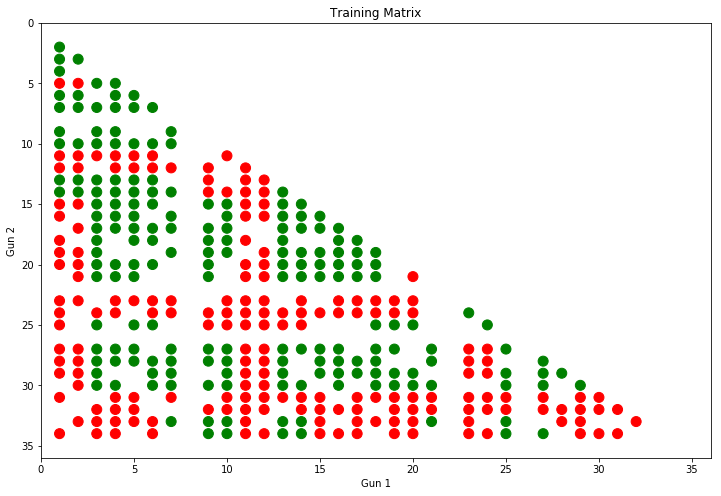

In [156]:
plotmatrix(training_one_config.gun1_num, training_one_config.gun2_num, training_one_config.legal, 'Training Matrix')

In [157]:
test_one_config = test_data[(test_data['filename'] == examplefile)]

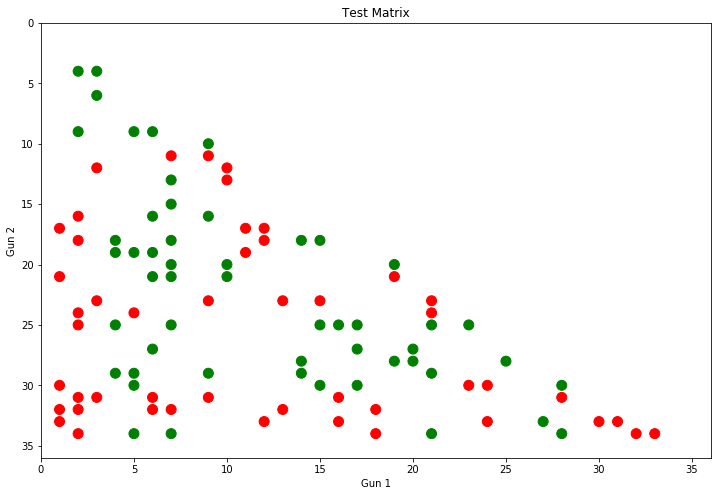

In [158]:
plotmatrix(test_one_config.gun1_num, test_one_config.gun2_num, test_one_config.legal, 'Test Matrix')

In [159]:
training_data = training_data.drop(["legal", "filename"], axis=1)
test_data_with_filename = test_data.drop(["legal"], axis=1)
test_data = test_data_with_filename.drop(["filename"], axis=1)
training_labels = training_labels["legal"]
test_labels = test_labels["legal"]

In [160]:
training_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
152,6,20,50,80,5
407,21,32,80,100,25
161,6,31,60,100,10
189,9,10,80,100,15
239,11,17,50,80,25


In [161]:
k_list, prediction, accuracies, recalls, precisions, f1 = knn(training_data, training_labels, test_data, test_labels, 101, 'binary')

1 :  0.878673835125448
3 :  0.9465949820788531
5 :  0.9587813620071685
7 :  0.9559139784946237
9 :  0.9494623655913978
11 :  0.942831541218638
13 :  0.9412186379928316
15 :  0.9410394265232975
17 :  0.9412186379928316
19 :  0.9417562724014337
21 :  0.9406810035842293
23 :  0.9388888888888889
25 :  0.9408602150537635
27 :  0.9388888888888889
29 :  0.9378136200716846
31 :  0.9405017921146953
33 :  0.9378136200716846
35 :  0.9363799283154122
37 :  0.9351254480286738
39 :  0.9347670250896057
41 :  0.9324372759856631
43 :  0.9311827956989247
45 :  0.9297491039426523
47 :  0.9283154121863799
49 :  0.9261648745519713
51 :  0.9240143369175627
53 :  0.9267025089605735
55 :  0.9263440860215054
57 :  0.9234767025089605
59 :  0.9232974910394265
61 :  0.9224014336917563
63 :  0.9222222222222223
65 :  0.921326164874552
67 :  0.9224014336917563
69 :  0.921326164874552
71 :  0.9218637992831541
73 :  0.9209677419354839
75 :  0.9193548387096774
77 :  0.9197132616487456
79 :  0.9202508960573477
81 :  0.9

k=3 is the sweetspot without normalization
k=5 is the sweetspot with costum normalization

In [162]:
training_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
152,6,20,50.0,80.0,5.0
407,21,32,80.0,100.0,25.0
161,6,31,60.0,100.0,10.0
189,9,10,80.0,100.0,15.0
239,11,17,50.0,80.0,25.0


In [163]:
def plotaccuracy(k_list, accuracies, recalls, precision, f1, title):
    plt.figure(figsize=(10, 8))
    plt.plot(k_list, accuracies, label='accuracy')
    plt.plot(k_list, recalls, label='recall')
    plt.plot(k_list, precision, label='precision')
    plt.plot(k_list, f1, label='f1')
    plt.legend()
    plt.xlabel("k")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.show()

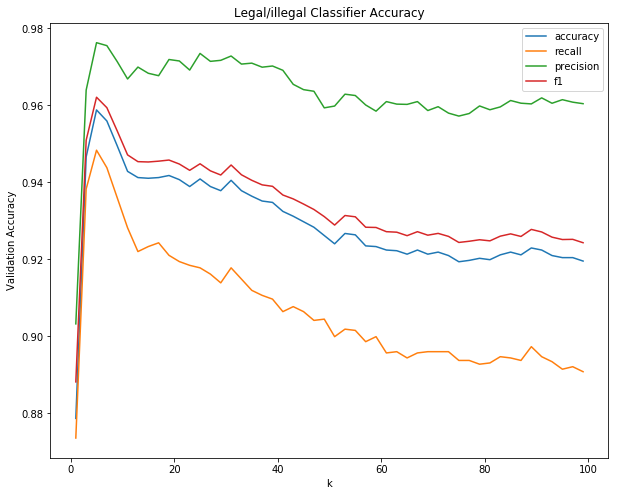

In [164]:
plotaccuracy(k_list, accuracies, recalls, precisions, f1, "Legal/illegal Classifier Accuracy")

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

In [165]:
training_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
152,6,20,50.0,80.0,5.0
407,21,32,80.0,100.0,25.0
161,6,31,60.0,100.0,10.0
189,9,10,80.0,100.0,15.0
239,11,17,50.0,80.0,25.0


In [166]:
test_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
249,11,29,90.0,100.0,25.0
457,30,33,70.0,100.0,25.0
365,18,25,60.0,100.0,15.0
97,4,16,70.0,100.0,15.0
48,2,23,90.0,100.0,25.0


In [167]:
#Running classification and prediction with best k
normalize_custom(training_data)
normalize_custom(test_data)
classifier = KNeighborsClassifier(n_neighbors = 5, p=1)
classifier.fit(training_data, training_labels)
print(classifier.score(test_data, test_labels))
y_predict = classifier.predict(test_data)
normalize_custom_inverse(training_data)
normalize_custom_inverse(test_data);


0.9587813620071685


In [168]:
training_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
152,6,20,50.0,80.0,5.0
407,21,32,80.0,100.0,25.0
161,6,31,60.0,100.0,10.0
189,9,10,80.0,100.0,15.0
239,11,17,50.0,80.0,25.0


In [169]:
test_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
249,11,29,90.0,100.0,25.0
457,30,33,70.0,100.0,25.0
365,18,25,60.0,100.0,15.0
97,4,16,70.0,100.0,15.0
48,2,23,90.0,100.0,25.0


In [170]:
#Running classification and prediction with best k
#classifier = KNeighborsClassifier(n_neighbors = 3)
#classifier.fit(training_data_norm, training_labels)
#print(classifier.score(test_data_norm, test_labels))
#y_predict = classifier.predict(test_data_norm)

In [171]:
cnf_matrix = metrics.confusion_matrix(test_labels, y_predict)

In [172]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[2432   71]
 [ 159 2918]]
Normalized confusion matrix
[[0.97163404 0.02836596]
 [0.05167371 0.94832629]]


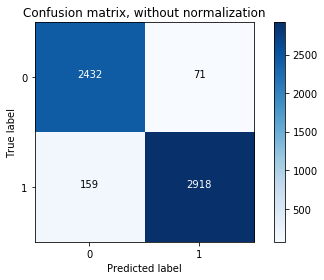

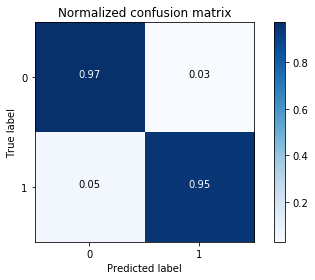

In [173]:
class_names = [0, 1]
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [174]:
len(y_predict)

5580

In [175]:
def prediction1(list):
    df = pd.DataFrame([list])
    return classifier.predict(df)

In [176]:
predicted_matrix = test_data_with_filename
predicted_matrix['legal'] = test_data.apply(lambda row: prediction1([row['gun1_num'], row['gun2_num'], row['Depth'], row['Subsep'], row['Temperature']]), axis=1)


In [177]:
#predicted_matrix

In [178]:
predicted_matrix_example = predicted_matrix[(predicted_matrix['filename'] == examplefile)]

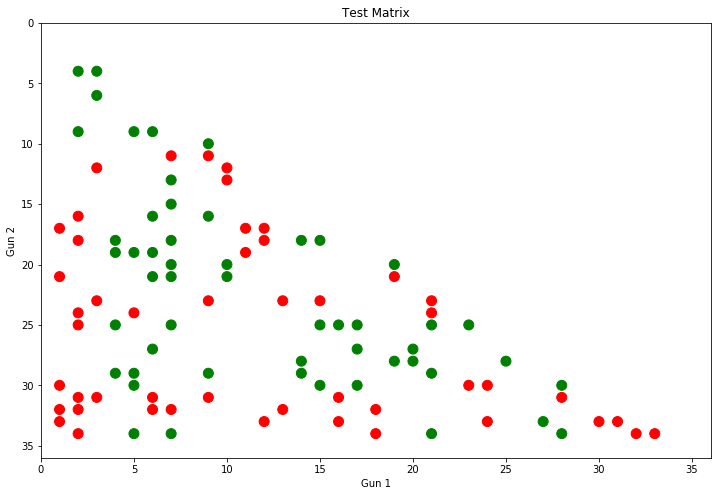

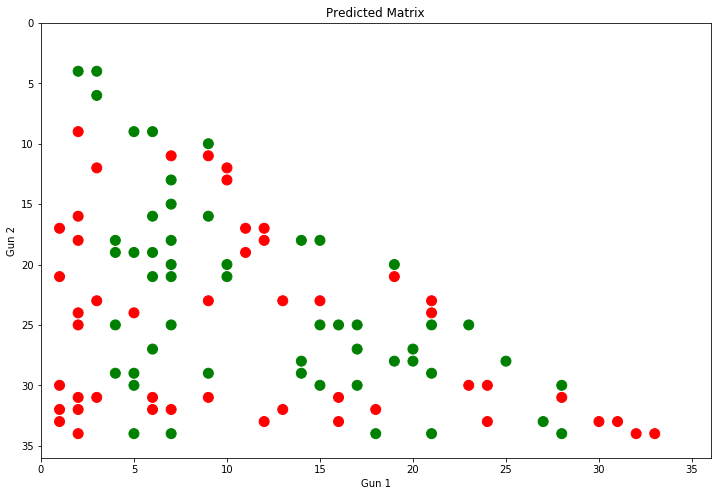

In [179]:
plotmatrix(test_one_config.gun1_num, test_one_config.gun2_num, test_one_config.legal, 'Test Matrix')

plotmatrix(predicted_matrix_example.gun1_num, predicted_matrix_example.gun2_num, predicted_matrix_example.legal, 'Predicted Matrix')

In [190]:
def plotmatrix_combine(x1, y1, legal1, x2, y2, legal2, title):
    plt.figure(figsize=(12, 8))
    color1= ['red' if l == 0 else 'green' for l in legal1]
    color2= ['red' if l == 0 else 'green' for l in legal2]
    plt.scatter(x1, y1, c=color1, s=100)
    plt.scatter(x2, y2, c=color2, s=100)
    plt.xlim(0, 36)
    plt.ylim(0, 36)
    plt.title(title)
    plt.xlabel("Gun 1")
    plt.ylabel("Gun 2")
    plt.gca().invert_yaxis()
    plt.show()

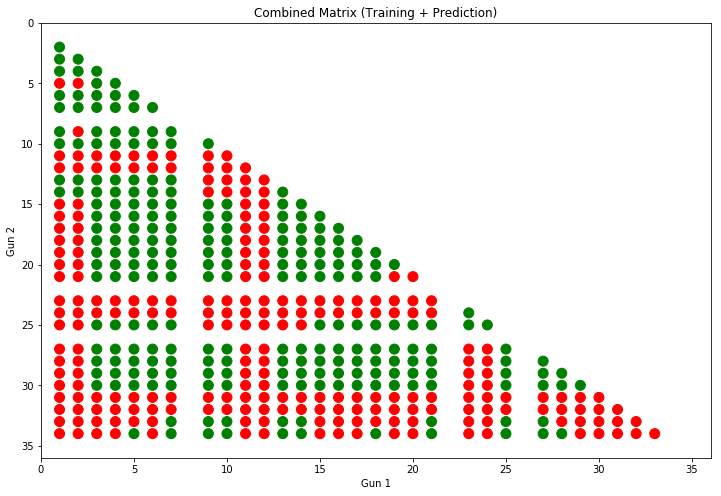

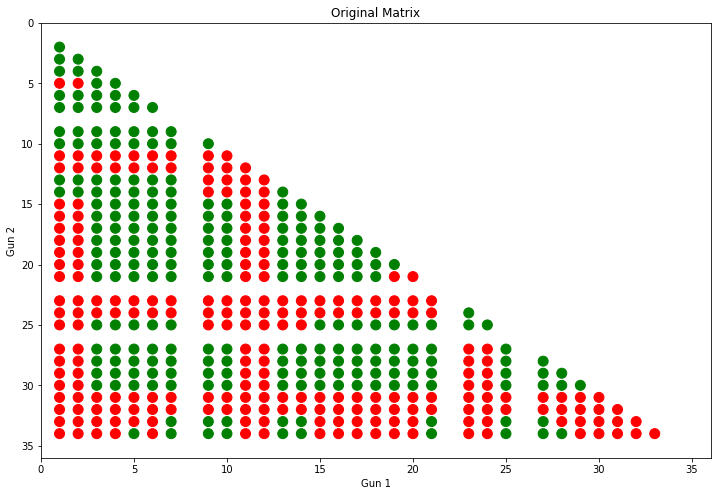

In [191]:
plotmatrix_combine(training_one_config.gun1_num, training_one_config.gun2_num, training_one_config.legal, predicted_matrix_example.gun1_num, predicted_matrix_example.gun2_num, predicted_matrix_example.legal, 'Combined Matrix (Training + Prediction)')
plotmatrix(ml_data_example.gun1_num, ml_data_example.gun2_num, ml_data_example.legal, 'Original Matrix')


In [182]:
test_data.head()

,gun1_num,gun2_num,Depth,Subsep,Temperature
249,11,29,90.0,100.0,25.0
457,30,33,70.0,100.0,25.0
365,18,25,60.0,100.0,15.0
97,4,16,70.0,100.0,15.0
48,2,23,90.0,100.0,25.0


In [183]:
test1 = [5, 15, 75, 95, 17]
df = pd.DataFrame([test1])
df = df.rename(columns={0: 'gun1_num', 1: 'gun2_num', 2: 'Depth', 3: 'Subsep', 4: 'Temperature'})

In [184]:
df

,gun1_num,gun2_num,Depth,Subsep,Temperature
0,5,15,75,95,17


In [185]:
normalize_custom(df)

,gun1_num,gun2_num,Depth,Subsep,Temperature
0,5,15,7.5,4.75,3.4


In [186]:
print("Predicted answer: ", classifier.predict(df))

Predicted answer:  [1]


In [187]:
normalize_custom_inverse(df)

,gun1_num,gun2_num,Depth,Subsep,Temperature
0,5,15,75.0,95.0,17.0
